## **Problem Statement:**

Train the agent to learn and win the card game, Blackjack using the off-policy MC method.

## **Environment**

* Game is played against a fixed dealer
* Game has a replacement or an infinite deck
* Moves:
  * Hit = Player asking for additional card
  * Stick = Player stops asking for the additional card
  * Bust = The sum of all cards exceeds 21
* Score of the cards:
  * Each of the cards Jack, Queen, and King have reward of 10
  * Each ace has a reward of 11 or 1 and is called unstable at 11
* Goal: Acquire cards that add up to 21 and must not go beyond 21.
* Rules:
  * Game starts with one card faced up and one card faced down for the player and the dealer
  * Player can ask for additional cards until the sum of the cards exceed 21 or player stops voluntarily
  * After the player sticks, the dealer will show the facedown card and draw cards from the deck until the sum is 17 or greater
  * After drawing cards, the player wins if the dealer exceeds the allowed sum of 21 and vice versa
  * If neither of them busts, the winner is decided by finding who has a score near to 21
* Action:
  * STICK = 0
  * HIT = 1
* Reward:
  * Win = +1
  * Draw = 0
  * Loss = -1
* Observation:
  * Current sum of players
  * Dealer's one showing card
  * Player having a usable ace or not

Environment courtsey: This environment corresponds to the version of the Blackjack problem described in Example 5.1 in<br> Reinforcement Learning: An Introduction by Sutton and Barto (1998), and OpenAI Gym.

## **Import the libraries and environment**

In [9]:
import matplotlib
import numpy as np
import sys
import collections
from collections import defaultdict
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import gym
env = gym.make("Blackjack-v1")

**Arguments:**

* policy: Maps an observation to action probabilities
* env: OpenAI Gym environment
* num_episodes: Number of episodes
* discount_factor: Gamma discount factor
* Q: A dictionary that maps from state -> action-values. Each value is a numpy array of length nA (see below)
* epsilon: Probability to select a random action float between 0 and 1
* nA: Number of actions in the environment
* Returns:
  * A = Function that takes the observation as an argument and returns the probabilities for each action in the form of a numpy array of length nA


### **Monte Carlo Off-Policy Control**

In [10]:
#Creating a random policy
def create_random_policy(nA):

    A = np.ones(nA, dtype=float) / nA
    def policy_fn(observation):
        return A
    return policy_fn

In [11]:
#Arguments:
#Q: A dictionary that maps from state-action values
#Returns: A function that returns a vector of action probabilities
def create_greedy_policy(Q):

    def policy_fn(state):
        A = np.zeros_like(Q[state], dtype=float)
        best_action = np.argmax(Q[state])
        A[best_action] = 1.0
        return A
    return policy_fn

In [12]:
#Monte Carlo Control: It is an off-policy control method that finds an optimal greedy policy.
#Arguments:
#env: Blackjack environment.
#num_episodes: Number of episodes for a sample
#behavior_policy: Following a behavior while generating episodes
#discount_factor: Gamma
#Returns:
#A = Tuple of Q and policy
#Q = Dictionary mapping state-action values.
#policy = Function that returns action probabilities. This is the optimal greedy policy.

def mc_control_importance_sampling(env, num_episodes, behavior_policy, discount_factor=1.0):


    # Final action-value function.
    # A dictionary that maps state-action values
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    # The cumulative denominator of the weighted importance sampling formula (across all episodes)
    C = defaultdict(lambda: np.zeros(env.action_space.n))

    # Our greedily policy we want to learn
    target_policy = create_greedy_policy(Q)

    for i_episode in range(1, num_episodes + 1):
        # Print out which episode we're on, useful for debugging.
        if i_episode % 1000 == 0:
            print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
            sys.stdout.flush()

        # Generate an episode.
        # An episode is an array of (state, action, reward) tuples
        episode = []
        state = env.reset()
        for t in range(100):
            # Sample an action from our policy
            probs = behavior_policy(state)
            action = np.random.choice(np.arange(len(probs)), p=probs)
            next_state, reward, done, _ = env.step(action)
            episode.append((state, action, reward))
            if done:
                break
            state = next_state

        # Sum of discounted returns
        G = 0.0
        # The importance sampling ratio (the weights of the returns)
        W = 1.0
        # For each step in the episode, backwards
        for t in range(len(episode))[::-1]:
            state, action, reward = episode[t]
            # Update the total reward since step t
            G = discount_factor * G + reward
            # Update weighted importance sampling formula denominator
            C[state][action] += W
            # Update the action-value function using the incremental update formula (5.7)
            # This also improves our target policy which holds a reference to Q
            Q[state][action] += (W / C[state][action]) * (G - Q[state][action])
            # If the action taken by the behavior policy is not the action
            # taken by the target policy the probability will be 0 and we can break
            if action !=  np.argmax(target_policy(state)):
                break
            W = W * 1./behavior_policy(state)[action]

    return Q, target_policy

#### **Episodes**

In [13]:
random_policy = create_random_policy(env.action_space.n)
Q, policy = mc_control_importance_sampling(env, num_episodes=500000, behavior_policy=random_policy)

Episode 500000/500000.

### **Create Plot Function**

In [14]:
def plot_value_function(V, title="Value Function"):

    min_x = min(k[0] for k in V.keys())
    max_x = max(k[0] for k in V.keys())
    min_y = min(k[1] for k in V.keys())
    max_y = max(k[1] for k in V.keys())

    x_range = np.arange(min_x, max_x + 1)
    y_range = np.arange(min_y, max_y + 1)
    X, Y = np.meshgrid(x_range, y_range)

    # Find value for all (x, y) coordinates
    Z_noace = np.apply_along_axis(lambda _: V[(_[0], _[1], False)], 2, np.dstack([X, Y]))
    Z_ace = np.apply_along_axis(lambda _: V[(_[0], _[1], True)], 2, np.dstack([X, Y]))

    def plot_surface(X, Y, Z, title):
        fig = plt.figure(figsize=(20, 10))
        ax = fig.add_subplot(111, projection='3d')
        surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1,
                               cmap=matplotlib.cm.coolwarm, vmin=-1.0, vmax=1.0)
        ax.set_xlabel('Player Sum')
        ax.set_ylabel('Dealer Showing')
        ax.set_zlabel('Value')
        ax.set_title(title)
        ax.view_init(ax.elev, -120)
        fig.colorbar(surf)
        plt.show()

    plot_surface(X, Y, Z_noace, "{} (No Usable Ace)".format(title))
    plot_surface(X, Y, Z_ace, "{} (Usable Ace)".format(title))

#### **Plot the Control**

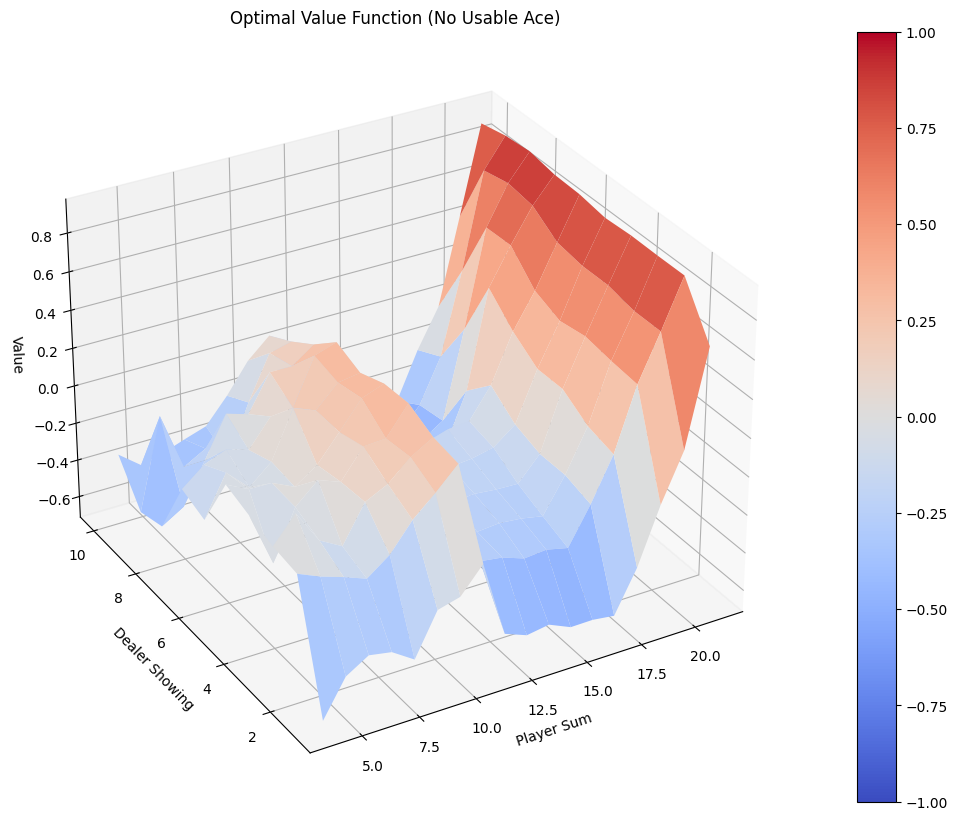

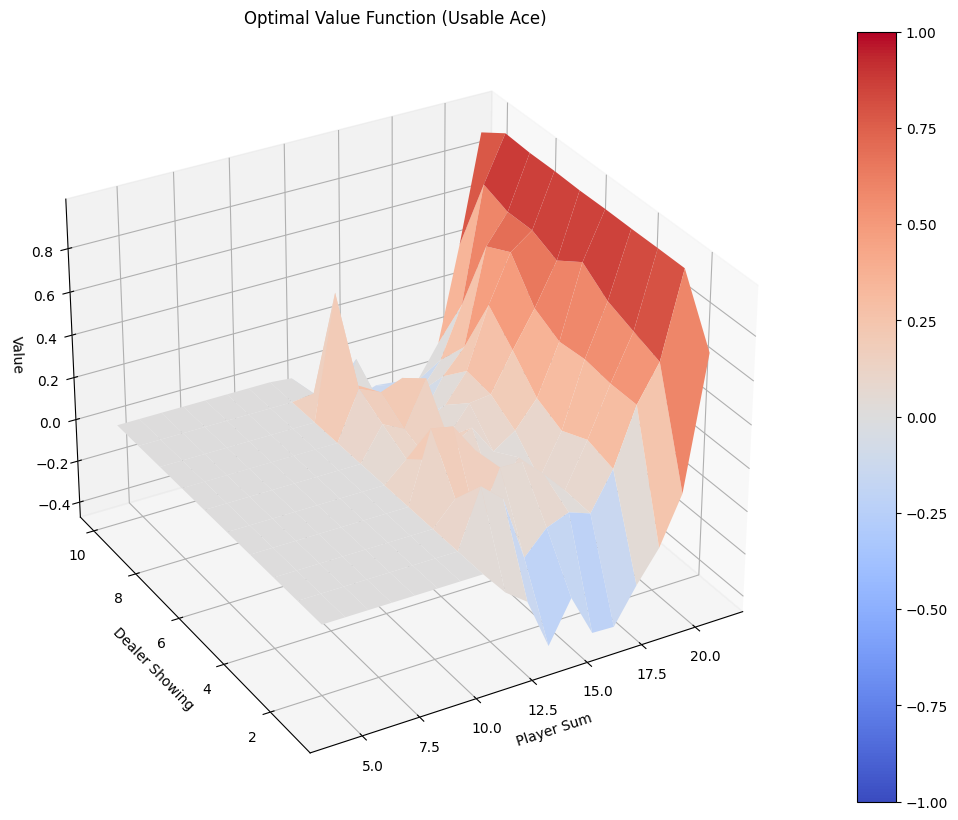

In [15]:
# For plotting: Create value function from action-value function
# by picking the best action at each state
V = defaultdict(float)
for state, action_values in Q.items():
    action_value = np.max(action_values)
    V[state] = action_value
plot_value_function(V, title="Optimal Value Function")